<a href="https://colab.research.google.com/github/yexf308/MAT592/blob/main/13_KNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline 
from IPython.display import Image
import numpy.linalg as LA

Populating the interactive namespace from numpy and matplotlib


Let's see how many machine learning algorithms we have explored. Remember we are implementing them from scratch. 

In [ ]:
Image(url='https://github.com/yexf308/MAT592/blob/main/image/ml_map.png?raw=true', width=900)

# $k$-Nearest Neighbors
Other than SVM, there are many other methods for classifications. $k$-Nearest Neighbors is one of them.

**Goal:** Given labeled dataset $\{\mathbf{x}^{(i)}, y^{(i)}\}_{i=1}^N$ and a sample $\mathbf{x}$ to be classified.

**Main idea:** 
1. select a value $k$ and a distance function $d(\mathbf{x},\mathbf{z})$.

2. compute the distance between $\mathbf{x}$ and the $N$ training samples.

3. Sort the distances obtained and take the $k$-nearest data samples, denoted
the set of their indices by $\mathcal{N}_k(\mathbf{x})$. 

4. prediction for the sample $\mathbf{x}$,
 
-   **Distribution:** Derive a distribution
over the outputs for the local region around $\mathbf{x}$
$$p(y=v|\mathbf{x})= \frac{\sum_{i\in\mathcal{N}_k(\mathbf{x})}\mathbb{1}_{\{v=y^{(i)}\}}}{k} $$

- **Classification**: 
1. Assign $\mathbf{x}$ to the class that has the greatest number of samples in $\mathcal{N}_k(\mathbf{x})$: i.e., based on the majority vote of its $k$-nearest neighbors.
$$ y = \text{arg}\min_v \sum_{i\in\mathcal{N}_k(\mathbf{x})}\mathbb{1}_{\{v=y^{(i)}\}}$$

2. Assign $\mathbf{x}$ to the class to the averaged response values of its k-nearest neighbors (if the averaging makes sense):
$$y= \frac{\sum_{i\in\mathcal{N}_k(\mathbf{x})}y^{(i)}}{k}. $$


Performance of the algorithm is influenced by the following four factors:
- **feature standardization** standardize the data (training and testing) so that features are on the same scale. 

- **distance function** $d(\mathbf{x},\mathbf{z})$ used to determine the nearest neighbors. 

- **number of neighbors**, i.e. value of $k$, used to classify the new sample.

- **decision rule** used to make a prediction from the nearest neighbors


In [ ]:
Image(url='https://github.com/yexf308/MAT592/blob/main/image/KnnClassification.png?raw=true', width=300)

### Feature standardization
- In the case where variables have very dierent measurement scales, then one variable will have a much higher influence on the distance calculated than another. Example: $x_1$ is measured in meters however, $x_2$ is measured in centimeters. 

- Standardize the data (training and testing) so that features are on the same scale:


> 1. **normalization:** for each dimension (variable) $x_j$ of any input $\mathbf{x}$,
$$\tilde{x}_j= \frac{x_j-\mu_j}{\sigma_j}$$
where $\mu$ is the mean and $\sigma$ is the standard deviation. Use $\tilde{\mathbf{x}}$ for K-NN instead of $\mathbf{x}$.

> 2. **min-max scaling:**
$$\tilde{x}_j= \frac{x_j-\min(x_j)}{\max(x_j)- \min(x_j)}$$



### Distance function
For continuous variable $\mathbf{x}$, 
1.   2-norm, $d(\mathbf{x},\mathbf{z})=\|\mathbf{x}-\mathbf{z}\|_2$
2.   1-norm(Manhattan), $d(\mathbf{x},\mathbf{z})=\|\mathbf{x}-\mathbf{z}\|_1$
3.  Mahalanobis distance, $d(\mathbf{x},\mathbf{z})= \sqrt{(\mathbf{x}-\mathbf{z})^\top M (\mathbf{x}-\mathbf{z})}$, where $M$ is a PSD and learnt from the data.

For discrete variable $\mathbf{x}$, 
1. Humming distance: $D_H(\mathbf{x},\mathbf{z})=\sum_{i=1}^d\mathbb{1}_{x_i\ne z_i}$.Count the number of features where the two examples disagree. Give an example. 

### Number of Neighbors $k$
This is the only parameter in $k$-NN needs to estimate. 

Model with too small $k$ tends to be sensitive to outliers; relatively larger $k$ (cannot be too large) gives better accuracy.

**$m$-fold cross validation** (this also applied to many ML algorithms), more commonly called $k$-fold.
- Fix a $k$ value, or more generally, some choice of
hyperparameters for a ML model.

- Partition training set into $m$ equal sized batches. One is retained as the validation (held-out) data for testing the model, and the remaining $m-1$ batches as training data.

- repeat $m$ times, with each of the $m$ subsets used exactly once as the validation data.

- refit: retrain the model using the optimal $k$ from cross validation on the whole training set.


### Decision rule
A more genernal way to define the decision rule with **weighted majority rule**.
$$y = \text{arg}\min_v \sum_{i\in\mathcal{N}_k(\mathbf{x})} w_i(\mathbf{x})\mathbb{1}_{\{v=y^{(i)}\}} $$
or if averaging could be defined,
$$ y = \frac{\sum_{i\in\mathcal{N}_k(\mathbf{x})} w_i(\mathbf{x})y^{(i)}}{\sum_{i\in\mathcal{N}_k(\mathbf{x})} w_i(\mathbf{x})}$$

Nearer neighbors should weigh more in voting.

heuristically, one can take $w_i(\mathbf{x})=\frac{1}{\|\mathbf{x}-\mathbf{x}^{(i)}\|}$ or $\frac{1}{\|\mathbf{x}-\mathbf{x}^{(i)}\|^2}$ or $1$.





---


Let's code it with the simpliest version. 

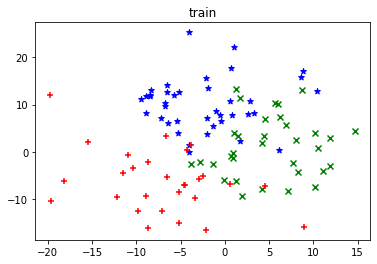

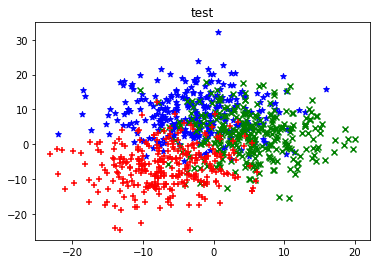

In [ ]:
#@title generate the dataset
from sklearn.datasets import make_blobs
from sklearn import metrics
import seaborn as sns

X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=6, random_state=42)
ntrain = 100
#  100 points as training
x_train = X[:ntrain]
y_train = y[:ntrain]
# 900 points as testing 
x_test = X[ntrain:]
y_test = y[ntrain:]


plt.figure()
y_unique = unique(y_train)
markers = '*x+'
colors = 'bgr'
for i in range(len(y_unique)):
  plt.scatter(x_train[y_train == y_unique[i], 0],
             x_train[y_train == y_unique[i], 1],
             marker=markers[i],
             c=colors[i])
plt.title('train')
plt.show()

plt.figure()
for i in range(len(y_unique)):
  plt.scatter(x_test[y_test == y_unique[i], 0],
             x_test[y_test == y_unique[i], 1],
             marker=markers[i],
             c=colors[i])
plt.title('test')
plt.show()


In [ ]:
#@title Create the multigrid to inference which class belongs to
x1 = np.linspace(np.min(x_test[:, 0]), np.max(x_test[:, 0]), 200)
x2 = np.linspace(np.min(x_test[:, 1]), np.max(x_test[:, 1]), 200)
xx1, xx2 = np.meshgrid(x1, x2)
xx = np.c_[xx1.ravel(), xx2.ravel()]
print(xx)

[[-23.09902095 -24.5224414 ]
 [-22.88244101 -24.5224414 ]
 [-22.66586108 -24.5224414 ]
 ...
 [ 19.5672262   32.13067507]
 [ 19.78380613  32.13067507]
 [ 20.00038607  32.13067507]]


In [ ]:
#@title my KNN implementation
def myknn_predict(k, x_train, y_train, x_test):
  labelEst = np.zeros(x_test.shape[0])
  for i, x in enumerate(x_test):
    dist            = norm(x_train - x, axis=1)
    dist_sort_index = argsort(dist)
    neigh_labels    = y_train[dist_sort_index[0:k]]
    labelEst[i]     = argmax(bincount(neigh_labels))
  return labelEst



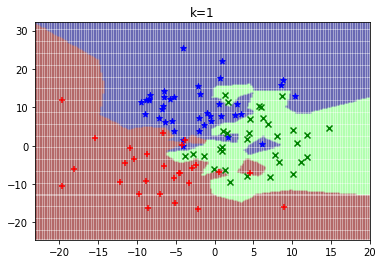

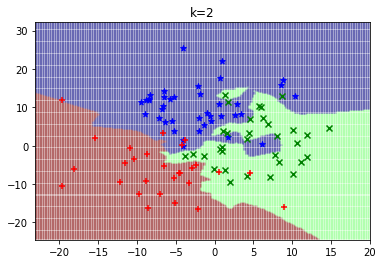

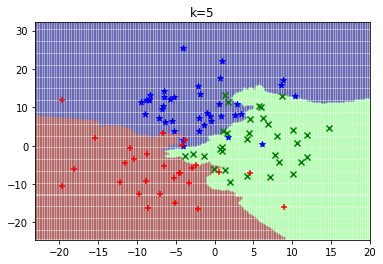

In [ ]:

#@title  use the knn model to predict when $k=1,2,5$ at these meshgrid

for k in [1, 2, 5]:
  y_predicted = myknn_predict(k, x_train, y_train, xx)
  plt.pcolormesh(xx1, xx2, y_predicted.reshape(200, 200), cmap='jet', alpha=0.2)
  for i in range(len(y_unique)):
        plt.scatter(x_train[y_train == y_unique[i], 0],
                  x_train[y_train == y_unique[i], 1],
                  marker=markers[i],
                  c=colors[i])
  plt.title('k=%s' % (k))
  plt.show()

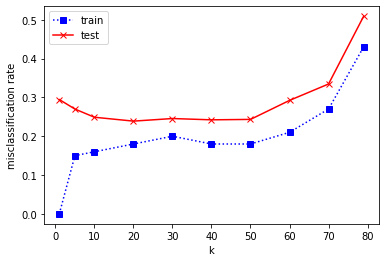

In [ ]:
#@title plot train err and test err with different k

ks         = [1, 5, 10, 20, 30, 40, 50, 60, 70, 79]
train_errs = []
test_errs  = []
N_train    = y_train.shape[0]
N_test     = y_test.shape[0]
for k in ks:
  y_train_predicted = myknn_predict(k, x_train, y_train, x_train)
  train_errs.append(norm(y_train_predicted - y_train,0)/N_train)

  y_test_predicted  = myknn_predict(k, x_train, y_train, x_test)
  test_errs.append(norm(y_test_predicted - y_test, 0)/N_test)

plt.figure()
plt.plot(ks, train_errs, 'bs:', label='train')
plt.plot(ks, test_errs, 'rx-', label='test')
plt.legend()
plt.xlabel('k')
plt.ylabel('misclassification rate')
plt.show()

Text(0.5, 1.0, '5-fold cross validation, n-train = 100')

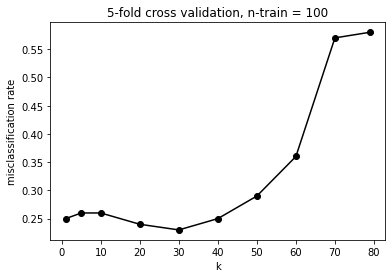

In [ ]:
#@title 4-fold cross_validate

scores     = []
CV         = 5
N_train    = y_train.shape[0]
batch      = N_train/CV
for k in ks:
  x_train_CV = split(x_train, CV)
  y_train_CV = split(y_train, CV)
  test_errs  = []
  for i in range(CV):
    index = delete(arange(CV),i)
    x_train_CV_i = vstack([x_train_CV[j] for j in index])
    y_train_CV_i = hstack([y_train_CV[j] for j in index])
    x_test_CV_i  = x_train_CV[i]
    y_test_CV_i  = y_train_CV[i]

    y_test_CV_i_predicted = myknn_predict(k, x_train_CV_i, y_train_CV_i, x_test_CV_i)
    test_errs.append(norm(y_test_CV_i_predicted - y_test_CV_i, 0)/batch)

  scores.append(mean(test_errs))  

plt.figure()
plt.plot(ks, scores, 'ko-')
plt.xlabel('k')
plt.ylabel('misclassification rate')
plt.title('5-fold cross validation, n-train = 100')





In [ ]:
#@title uility function
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, \
                xlabel='Estimations', ylabel='True values');

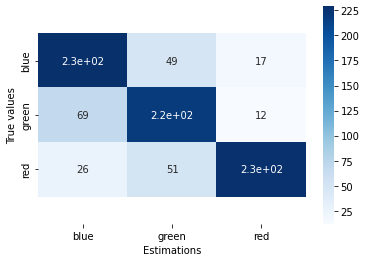

In [ ]:
#@title plot confusion matrix at K = 10
k = 10
y_test_predicted  = myknn_predict(k, x_train, y_train, x_test)
plotConfusionMatrix(y_test, y_test_predicted, np.array(['blue', 'green','red']));

In [ ]:
#@title draw hot-map to show the probability of different class for K=10
def myknn_predict_prob(k, x_train, y_train, x_test, y_class):
  labelEst_prob = np.zeros(x_test.shape[0])
  for i, x in enumerate(x_test):
    dist            = norm(x_train - x, axis=1)
    dist_sort_index = argsort(dist)
    neigh_labels    = y_train[dist_sort_index[0:k]]
    labelEst_prob[i]     = sum(neigh_labels == y_class)/k
  return labelEst_prob

k = 10
levels = np.arange(0, 1.01, 0.1)
for i in range(3):  
  y_predicted_prob = myknn_predict_prob(k, x_train, y_train, xx, i)
  plt.figure()
  plt.contourf(y_predicted_prob.reshape(200, 200), levels)
  plt.colorbar()
  plt.title('p(y=%s | data, k=10)' % (i))
